In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            # Split label and question
            label, question = line.strip().split(' ', 1)
            data.append({"question": question, "label": label})
    return pd.DataFrame(data)

train_set = load_data(".\data\\train_set5.txt")
test_set = load_data(".\data\\test_set.txt")

print(train_set.head())


                                            question        label
0  How did serfdom develop in and then leave Russ...  DESC:manner
1   What films featured the character Popeye Doyle ?  ENTY:cremat
2  How can I find a list of celebrities ' real na...  DESC:manner
3  What fowl grabs the spotlight after the Chines...  ENTY:animal
4                    What is the full form of .com ?     ABBR:exp


In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words and ensure WH-questions are retained
stop_words = set(stopwords.words('english'))
wh_questions = {"what", "where", "who", "when", "why", "how"}  # WH-questions
stop_words -= wh_questions  # Remove WH-questions from the stop words set

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Filter stop words (excluding WH-questions)
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # Rejoin words into a single string
    return ' '.join(words)

# Apply preprocessing to training and test sets
train_set['processed_question'] = train_set['question'].apply(preprocess_text)
test_set['processed_question'] = test_set['question'].apply(preprocess_text)


In [4]:
train_set['processed_question'].head()

0                how serfdom develop leave russia
1       what film featured character popeye doyle
2               how find list celebrity real name
3    what fowl grab spotlight chinese year monkey
4                              what full form com
Name: processed_question, dtype: object

In [5]:
train_set[['category', 'specific_type']] = train_set['label'].str.split(':', expand=True)
test_set[['category', 'specific_type']] = test_set['label'].str.split(':', expand=True)

print(train_set[['label', 'category', 'specific_type']].head())


         label category specific_type
0  DESC:manner     DESC        manner
1  ENTY:cremat     ENTY        cremat
2  DESC:manner     DESC        manner
3  ENTY:animal     ENTY        animal
4     ABBR:exp     ABBR           exp


In [6]:
category_encoder = LabelEncoder()
specific_type_encoder = LabelEncoder()

train_set['category_encoded'] = category_encoder.fit_transform(train_set['category'])
train_set['specific_type_encoded'] = specific_type_encoder.fit_transform(train_set['specific_type'])

test_set['category_encoded'] = category_encoder.transform(test_set['category'])
test_set['specific_type_encoded'] = specific_type_encoder.transform(test_set['specific_type'])

print(train_set[['category', 'specific_type', 'category_encoded', 'specific_type_encoded']].head())


  category specific_type  category_encoded  specific_type_encoded
0     DESC        manner                 1                     23
1     ENTY        cremat                 2                      8
2     DESC        manner                 1                     23
3     ENTY        animal                 2                      1
4     ABBR           exp                 0                     16


In [7]:
train_set['combined_label'] = train_set['category'] + "_" + train_set['specific_type']
test_set['combined_label'] = test_set['category'] + "_" + test_set['specific_type']

combined_label_encoder = LabelEncoder()
train_set['combined_label_encoded'] = combined_label_encoder.fit_transform(train_set['combined_label'])
test_set['combined_label_encoded'] = combined_label_encoder.transform(test_set['combined_label'])

print(train_set[['combined_label', 'combined_label_encoded']].head())


  combined_label  combined_label_encoded
0    DESC_manner                       4
1    ENTY_cremat                       9
2    DESC_manner                       4
3    ENTY_animal                       6
4       ABBR_exp                       1


In [8]:
train_set.head()

,question,label,processed_question,category,specific_type,category_encoded,specific_type_encoded,combined_label,combined_label_encoded
0,How did serfdom develop in and then leave Russ...,DESC:manner,how serfdom develop leave russia,DESC,manner,1,23,DESC_manner,4
1,What films featured the character Popeye Doyle ?,ENTY:cremat,what film featured character popeye doyle,ENTY,cremat,2,8,ENTY_cremat,9
2,How can I find a list of celebrities ' real na...,DESC:manner,how find list celebrity real name,DESC,manner,1,23,DESC_manner,4
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,what fowl grab spotlight chinese year monkey,ENTY,animal,2,1,ENTY_animal,6
4,What is the full form of .com ?,ABBR:exp,what full form com,ABBR,exp,0,16,ABBR_exp,1


## tf-idf for embedding

### LogisticRegression Model

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_set['processed_question']).toarray()
X_test = vectorizer.transform(test_set['processed_question']).toarray()

# Logistic Regression Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_set['combined_label_encoded'])
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(test_set['combined_label_encoded'], y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.62      0.77         8
           2       0.74      0.98      0.85       123
           3       0.38      0.43      0.40         7
           4       0.13      1.00      0.24         2
           5       1.00      0.83      0.91         6
           6       1.00      0.38      0.55        16
           7       0.00      0.00      0.00         2
           8       1.00      0.90      0.95        10
          10       0.00      0.00      0.00         6
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       1.00      0.25      0.40         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.38      0.42      0.40        12
          18       0.00      0.00      0.00         5
    

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

## Imbalanced data so we did oversampling

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, train_set['combined_label_encoded'])


In [11]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into training and validation sets
X_train_balanced_train, X_val, y_train_balanced_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)


In [19]:
# Logistic Regression Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_balanced_train, y_train_balanced_train)
# Predictions on the test set
y_test_pred = clf.predict(X_test)
y_test = test_set['combined_label_encoded']


# Test set evaluation
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      0.75      0.71         8
           2       0.88      0.76      0.82       123
           3       0.27      0.43      0.33         7
           4       0.67      1.00      0.80         2
           5       0.83      0.83      0.83         6
           6       0.69      0.69      0.69        16
           7       0.50      1.00      0.67         2
           8       1.00      1.00      1.00        10
          10       0.71      0.83      0.77         6
          11       0.50      0.50      0.50         2
          12       0.50      0.50      0.50         2
          13       0.50      0.50      0.50         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.20      0.58      0.30        12
          18       1.00      0.40      0.57      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Example: Training a Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_balanced_train, y_train_balanced_train)


RandomForestClassifier(random_state=42)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on the validation set
y_val_pred = clf.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       207
           1       0.98      0.88      0.93       214
           2       0.71      0.94      0.81       194
           3       0.96      0.85      0.90       182
           4       0.99      0.99      0.99       196
           5       1.00      0.97      0.99       192
           6       0.99      0.98      0.98       190
           7       1.00      1.00      1.00       176
           8       0.99      1.00      0.99       179
           9       0.97      0.97      0.97       183
          10       1.00      1.00      1.00       200
          11       0.96      0.99      0.98       187
          12       0.97      0.98      0.97       178
          13       1.00      0.97      0.99       197
          14       1.00      1.00      1.00       175
          15       1.00      1.00      1.00       203
          16       1.00      1.00      1.00       204
    

In [14]:
# Predictions on the test set
y_test_pred = clf.predict(X_test)
y_test = test_set['combined_label_encoded']


# Test set evaluation
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      0.75      0.71         8
           2       0.74      0.96      0.84       123
           3       0.60      0.43      0.50         7
           4       0.50      1.00      0.67         2
           5       0.83      0.83      0.83         6
           6       0.75      0.56      0.64        16
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00        10
          10       0.62      0.83      0.71         6
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       1.00      0.25      0.40         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.33      0.25      0.29        12
          18       1.00      0.40      0.57      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [15]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  1   0   0 ...   0   0   0]
 [  0   6   2 ...   0   0   0]
 [  0   3 118 ...   0   0   0]
 ...
 [  0   0   1 ...   4   0   0]
 [  0   0   0 ...   0   4   0]
 [  0   0   0 ...   0   0   4]]


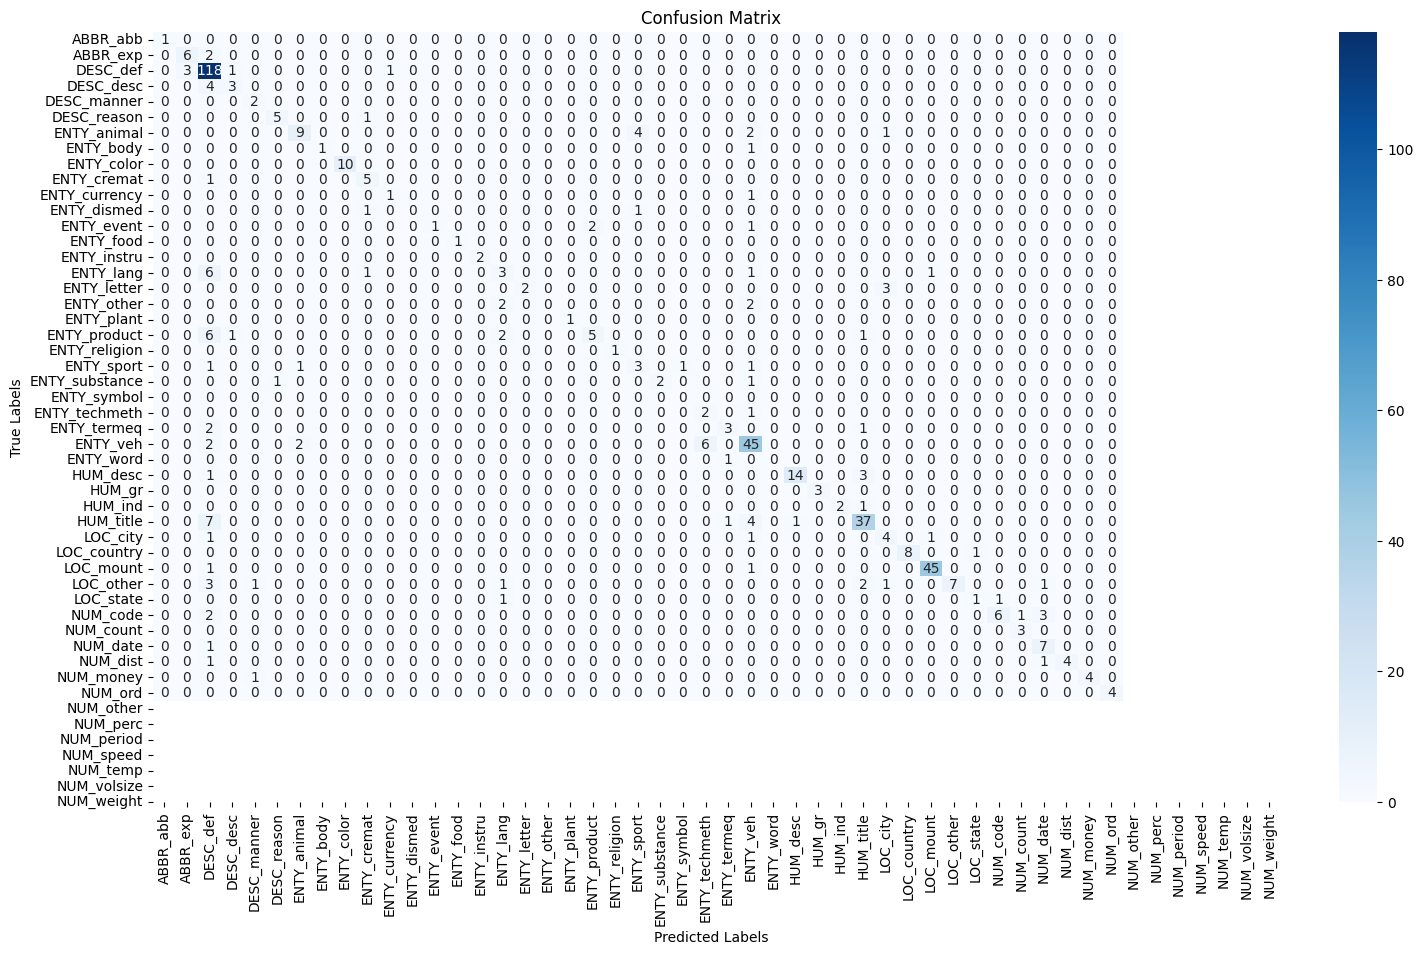

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(18, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=combined_label_encoder.classes_, yticklabels=combined_label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


## option 2 for inbalanced data : we use model that supports it which is XGBoost

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.75      0.75         8
           2       0.75      0.99      0.86       123
           3       0.43      0.43      0.43         7
           4       0.40      1.00      0.57         2
           5       0.83      0.83      0.83         6
           6       1.00      0.56      0.72        16
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00        10
           9       0.00      0.00      0.00         0
          10       0.33      0.17      0.22         6
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         2
          13       0.50      0.25      0.33         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.21      0.25      0.23      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

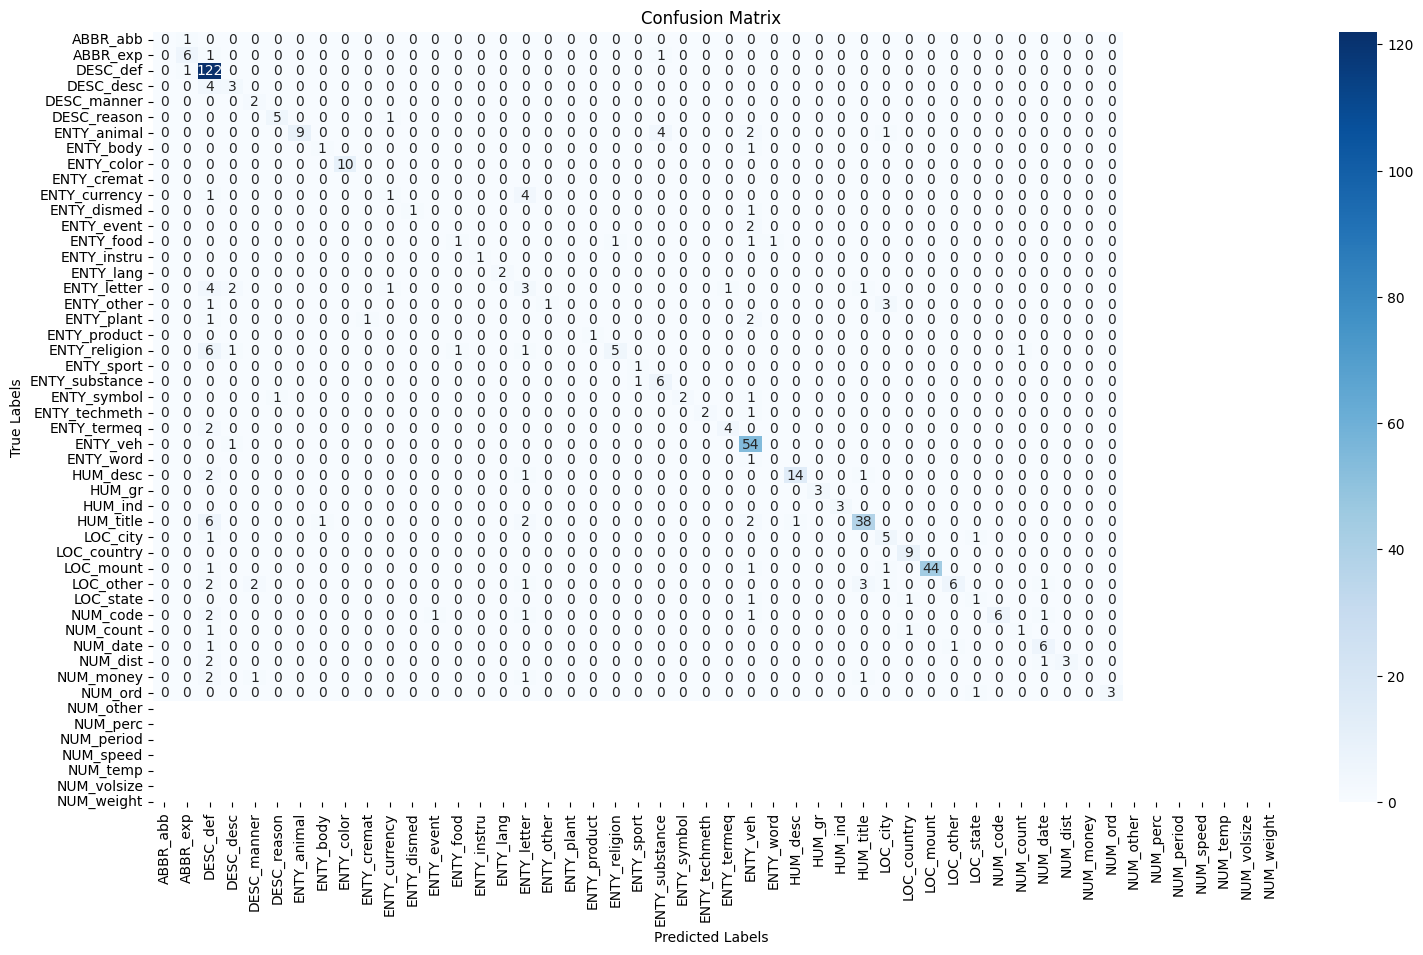

In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# TF-IDF Vectorization (unchanged)
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_set['processed_question']).toarray()
X_test = vectorizer.transform(test_set['processed_question']).toarray()

# Use XGBoost Classifier instead of RandomForest
clf = xgb.XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='mlogloss')

# Training the model
clf.fit(X_train, train_set['combined_label_encoded'])

# Predictions on the test set
y_test_pred = clf.predict(X_test)

# Generate the classification report
print("Test Set Classification Report:")
print(classification_report(test_set['combined_label_encoded'], y_test_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_set['combined_label_encoded'], y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=combined_label_encoder.classes_, yticklabels=combined_label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.75      0.75         8
           2       0.75      0.98      0.85       123
           3       0.43      0.43      0.43         7
           4       0.40      1.00      0.57         2
           5       0.83      0.83      0.83         6
           6       1.00      0.50      0.67        16
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00        10
           9       0.00      0.00      0.00         0
          10       0.33      0.17      0.22         6
          11       0.33      0.50      0.40         2
          12       0.00      0.00      0.00         2
          13       0.60      0.75      0.67         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.21      0.33      0.26      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

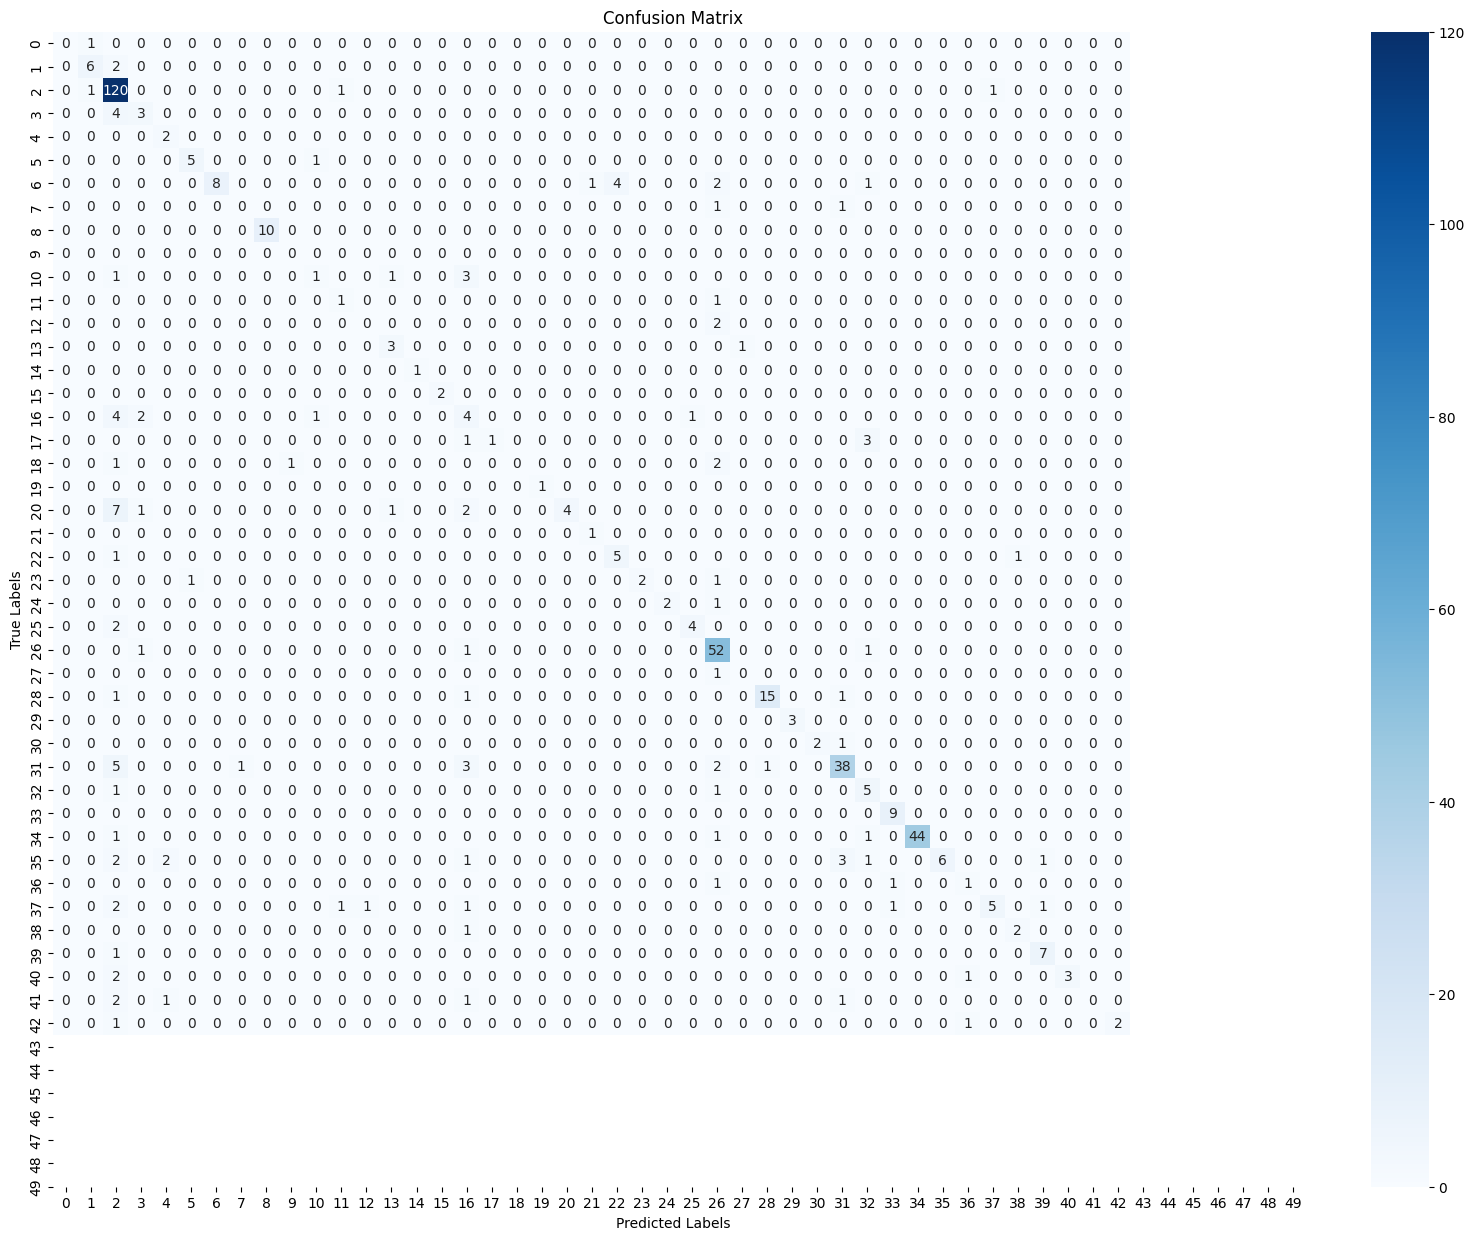

In [29]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Calculate class counts dynamically
class_counts = Counter(train_set['combined_label_encoded'])

# Total samples in the training set
total_samples = sum(class_counts.values())

# Calculate scale_pos_weight for each class
scale_pos_weight = {label: total_samples / count for label, count in class_counts.items()}

# Create a list of weights in the order of the class labels
weights = [scale_pos_weight[label] for label in np.unique(train_set['combined_label_encoded'])]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_set['processed_question']).toarray()
X_test = vectorizer.transform(test_set['processed_question']).toarray()

# Initialize XGBoost Classifier with adjusted weights
clf = xgb.XGBClassifier(
    use_label_encoder=False,
    random_state=42,
    eval_metric='mlogloss',       # Multiclass log loss
    scale_pos_weight=weights,     # Dynamic class balancing
    max_depth=6,                  # Limit tree depth
    learning_rate=0.1,            # Step size shrinkage
    n_estimators=200,             # Number of boosting rounds
    subsample=0.8,                # Row sampling
    colsample_bytree=0.8          # Feature sampling
)

# Train the model
clf.fit(X_train, train_set['combined_label_encoded'])

# Predictions on the test set
y_test_pred = clf.predict(X_test)

# Generate the classification report
print("Test Set Classification Report:")
print(classification_report(test_set['combined_label_encoded'], y_test_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_set['combined_label_encoded'], y_test_pred)

# Visualize the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues", 
    xticklabels=np.unique(train_set['combined_label_encoded']),
    yticklabels=np.unique(train_set['combined_label_encoded'])
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Class distribution after SMOTE: Counter({4: 962, 9: 962, 6: 962, 1: 962, 30: 962, 29: 962, 31: 962, 2: 962, 39: 962, 5: 962, 12: 962, 36: 962, 3: 962, 38: 962, 17: 962, 16: 962, 35: 962, 20: 962, 13: 962, 33: 962, 8: 962, 25: 962, 32: 962, 7: 962, 11: 962, 34: 962, 41: 962, 19: 962, 45: 962, 22: 962, 21: 962, 18: 962, 24: 962, 48: 962, 28: 962, 14: 962, 0: 962, 43: 962, 46: 962, 27: 962, 15: 962, 44: 962, 37: 962, 40: 962, 47: 962, 23: 962, 42: 962, 26: 962, 49: 962, 10: 962})


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:58:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.62      0.62      0.62         8
           2       0.78      0.95      0.86       123
           3       0.75      0.43      0.55         7
           4       0.50      1.00      0.67         2
           5       0.83      0.83      0.83         6
           6       0.67      0.38      0.48        16
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00        10
          10       0.50      0.33      0.40         6
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       1.00      0.50      0.67         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.33      0.50      0.40        12
          18       1.00      0.40      0.57      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

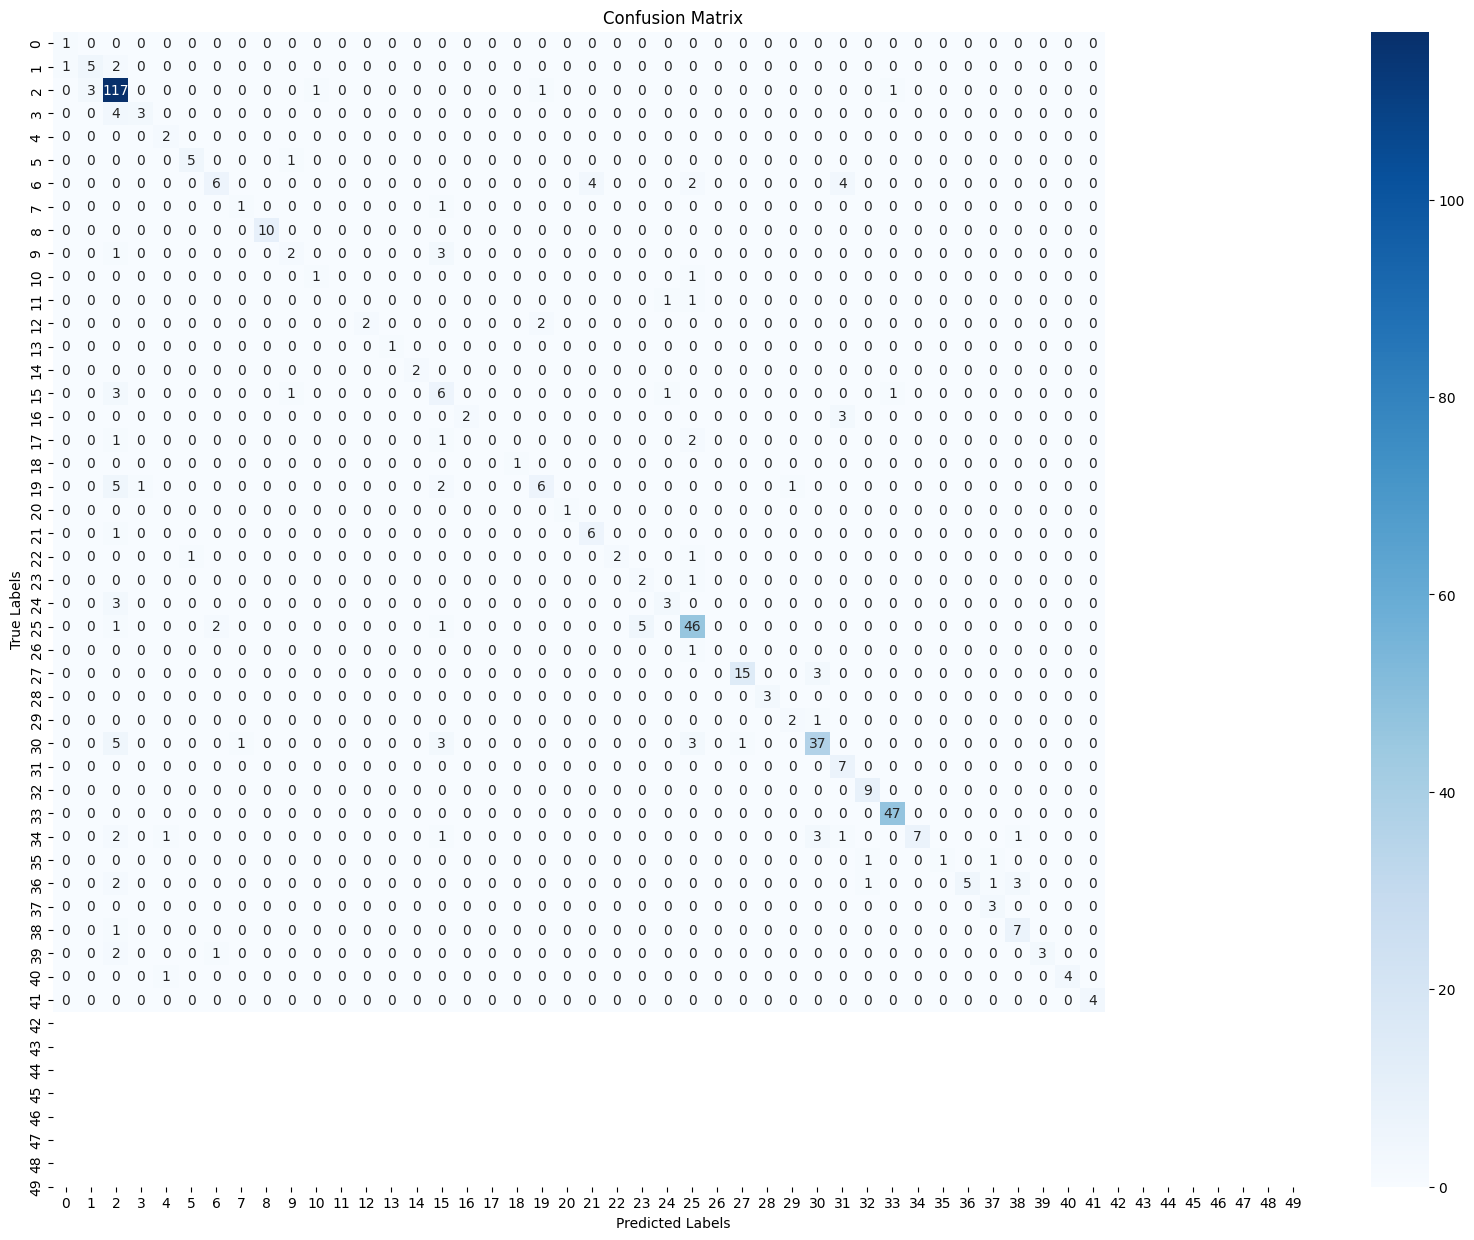

In [30]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_set['processed_question']).toarray()
X_test = vectorizer.transform(test_set['processed_question']).toarray()

# SMOTE for class balancing
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, train_set['combined_label_encoded'])

# Verify new class distribution
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_train_balanced))

# Initialize XGBoost Classifier
clf = xgb.XGBClassifier(
    use_label_encoder=False,
    random_state=42,
    eval_metric='mlogloss',       # Multiclass log loss
    max_depth=6,                  # Limit tree depth
    learning_rate=0.1,            # Step size shrinkage
    n_estimators=200,             # Number of boosting rounds
    subsample=0.8,                # Row sampling
    colsample_bytree=0.8          # Feature sampling
)

# Train the model on balanced data
clf.fit(X_train_balanced, y_train_balanced)

# Predictions on the test set
y_test_pred = clf.predict(X_test)

# Generate the classification report
print("Test Set Classification Report:")
print(classification_report(test_set['combined_label_encoded'], y_test_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_set['combined_label_encoded'], y_test_pred)

# Visualize the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues", 
    xticklabels=np.unique(train_set['combined_label_encoded']),
    yticklabels=np.unique(train_set['combined_label_encoded'])
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### XGboost + SMOTE

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.62      0.62      0.62         8
           2       0.76      0.95      0.84       123
           3       0.50      0.43      0.46         7
           4       0.50      1.00      0.67         2
           5       0.83      0.83      0.83         6
           6       1.00      0.38      0.55        16
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00        10
          10       0.33      0.17      0.22         6
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       1.00      0.50      0.67         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.35      0.58      0.44        12
          18       1.00      0.20      0.33      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

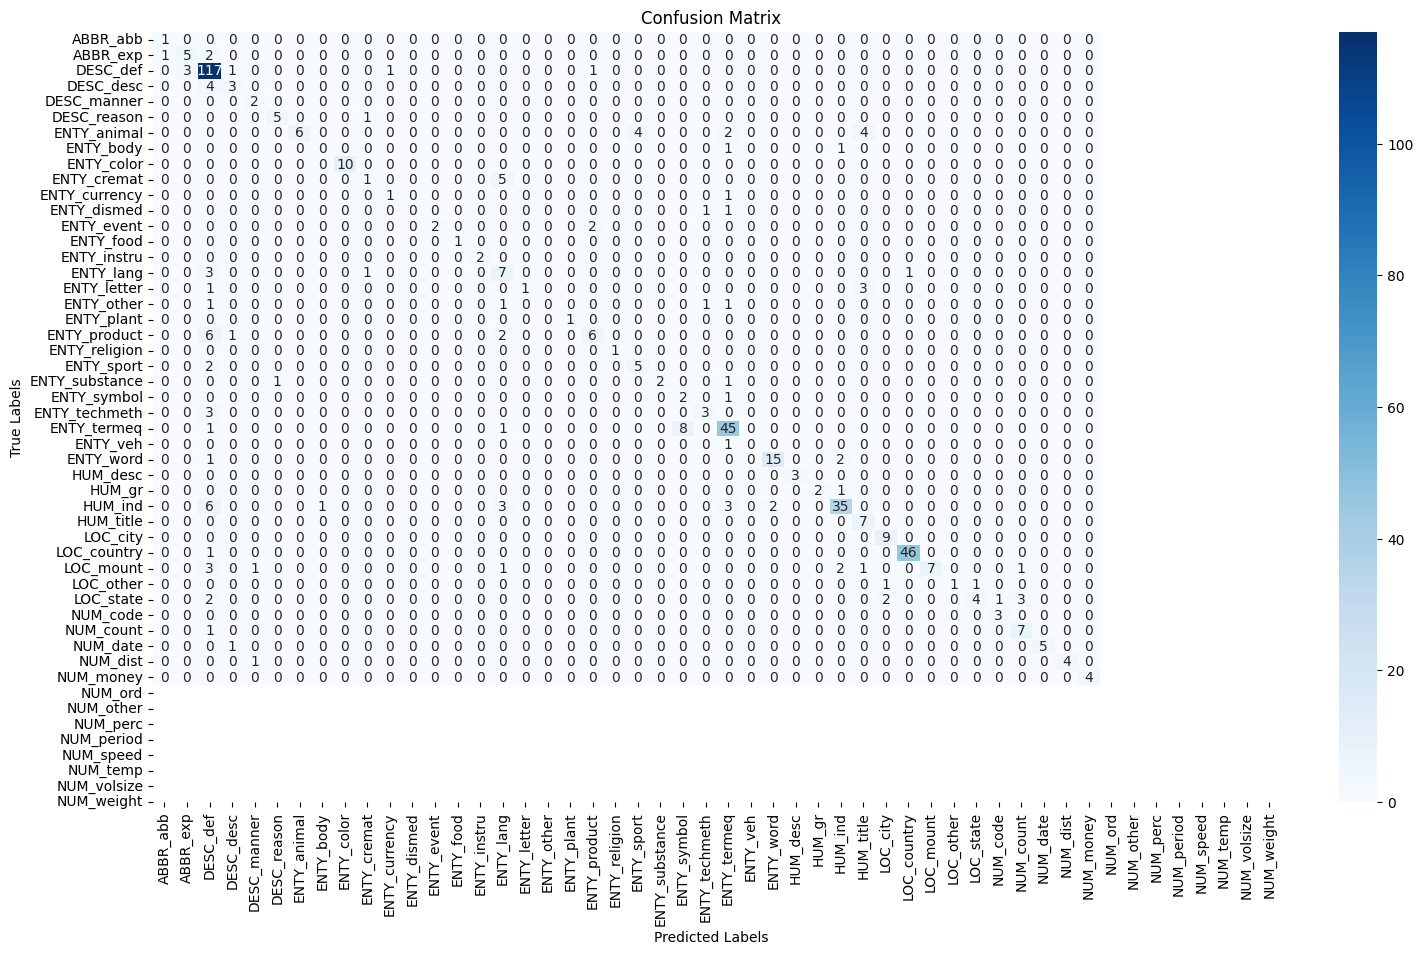

In [20]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# TF-IDF Vectorization (unchanged)
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_set['processed_question']).toarray()
X_test = vectorizer.transform(test_set['processed_question']).toarray()

# Use XGBoost Classifier instead of RandomForest
clf = xgb.XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='mlogloss')

clf.fit(X_train_balanced_train, y_train_balanced_train)
# Predictions on the test set
y_test_pred = clf.predict(X_test)

# Generate the classification report
print("Test Set Classification Report:")
print(classification_report(test_set['combined_label_encoded'], y_test_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_set['combined_label_encoded'], y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=combined_label_encoder.classes_, yticklabels=combined_label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 500]
}

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                           param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit grid search
grid_search.fit(X_train, train_set['combined_label_encoded'])

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
clf = grid_search.best_estimator_

# Retrain with best parameters
clf.fit(X_train, train_set['combined_label_encoded'])
y_test_pred = clf.predict(X_test)

# Evaluate on test set
print("Test Set Classification Report:")
print(classification_report(test_set['combined_label_encoded'], y_test_pred))


Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } 

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.75      0.75         8
           2       0.73      0.99      0.84       123
           3       0.60      0.43      0.50         7
           4       0.40      1.00      0.57         2
           5       0.83      0.83      0.83         6
           6       1.00      0.44      0.61        16
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00        10
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         6
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       0.50      0.25      0.33         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.27      0.33      0.30      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

## Word2Vec Embedding

In [23]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Training Word2Vec model
tokenized_text = train_set['processed_question'].tolist()
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average Word2Vec embedding for a question
def get_word2vec_embedding(sentence, model):
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

# Apply the function to both train and test sets
train_set['word2vec'] = train_set['processed_question'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))
test_set['word2vec'] = test_set['processed_question'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))

# Prepare the features and target variable
X_train = np.vstack(train_set['word2vec'])
X_test = np.vstack(test_set['word2vec'])
y_train = train_set['combined_label_encoded']
y_test = test_set['combined_label_encoded']



In [24]:
# Logistic Regression Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.61      0.76      0.68       123
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          17       0.00      0.00      0.00        12
          18       0.00      0.00      0.00         5
    

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Apply SMOTE with a smaller number of neighbors
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [27]:
# Train the Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.03      1.00      0.05         1
           1       0.17      0.75      0.28         8
           2       0.77      0.47      0.59       123
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00         2
           8       0.07      0.10      0.08        10
           9       0.00      0.00      0.00         0
          10       0.07      0.17      0.10         6
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         4
          14       0.03      1.00      0.06         1
          15       0.02      0.50      0.05         2
          16       0.00      0.00      0.00         0
    

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [28]:
clf = xgb.XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='mlogloss')

# Training the model
clf.fit(X_train, y_train)

# Predictions on the test set
y_test_pred = clf.predict(X_test)

# Generate the classification report
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.56      0.62      0.59         8
           2       0.69      0.74      0.72       123
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         2
           5       0.29      0.33      0.31         6
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.25      0.25      0.25         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          17       0.00      0.00      0.00      

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi